In [1]:
"""Scripts for analyzing of phantom outputs.

This script analyze the photospheric properties by randomly select rays in 3D space

"""

'Scripts for analyzing of phantom outputs.\n\nThis script analyze the photospheric properties by randomly select rays in 3D space\n\n'

# Main

## Imports & Settings

In [2]:
import numpy as np
from numpy import pi
from astropy import units
import matplotlib.pyplot as plt
import matplotlib as mpl
#from moviepy.editor import ImageSequenceClip
#from os import path

In [3]:
# import my modules listed in ./main/

from main import clmuphantomlib as mupl
#from main.clmuphantomlib.readwrite import json_load
from main.clmuphantomlib.log import is_verbose, say
from main.clmuphantomlib.settings   import DEFAULT_SETTINGS as settings
from main.clmuphantomlib.units_util import get_val_in_unit #set_as_quantity, get_units_field_name, get_units_cgs
from main.clmuphantomlib.readwrite  import json_dump, json_load
from main.clmuphantomlib.eos_mesa   import EoS_MESA_opacity
from main.clmuphantomlib import MyPhantomDataFrames, get_eos
from main.clmuphantomlib.light import get_optical_depth_by_ray_tracing_3D, get_photosphere_on_ray
from multiprocessing import cpu_count, Pool #Process, Queue
NPROCESSES = 1 if cpu_count() is None else max(cpu_count(), 1)

/home/clmu/anaconda3/envs/clmu_1/lib/python3.11/site-packages/sarracen/kernels/cubic_spline.py:15: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(fastmath=True)
/home/clmu/anaconda3/envs/clmu_1/lib/python3.11/site-packages/sarracen/kernels/quartic_spline.py:15: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(fastmath=True)
/home/clmu/anaconda3/envs/clmu_1

In [4]:
# settings
#
#   imported from script_input.py file


from script_PhLocRand__input import verbose, fps, unitsOut, JOB_PROFILES_DICT, PHOTOSPHERE_TAU, ray_no, cos_theta_sample_no

unitsOutTxt = {  key  : unitsOut[key].to_string('latex_inline') for key in unitsOut.keys() }


# set metadata
with open("_metadata__input.json", 'r') as f:
    metadata = json_load(f)
metadata['Title'] = "Getting photosphere values (temperature, size) with random sampling on rays"
metadata['Description'] = f"""Tracing ({ray_no=}) of rays with random directions.
photosphere is defined as where optical depth reaches {PHOTOSPHERE_TAU}.
Results are the values at the intersection point between the photosphere and the rays.
rays all originates from the primary star (sdf_sink.iloc[0])
"""


plt.rcParams.update({'font.size': 20})
if __name__ == '__main__' and is_verbose(verbose, 'note'):
    # remember to check if name is '__main__' if you wanna say anything
    #    so when you do multiprocessing the program doesn't freak out
    say('note', "script", verbose, f"Will use {NPROCESSES} processes for parallelization")


*   Note   :    script:
	Will use 8 processes for parallelization


In [5]:
def mpdf_read(
    job_name: str,
    file_index: int,
    eos_opacity: EoS_MESA_opacity,
    mpdf: MyPhantomDataFrames|None = None,
    verbose: int = 3,
) -> MyPhantomDataFrames:
    """Read the dump files and get T and kappa."""
    if mpdf is None:
        mpdf = MyPhantomDataFrames()

    mpdf.read(job_name, file_index, verbose=verbose)
    temp_key = {'T', 'temperature', 'Tdust'}.intersection(mpdf.data['gas'].keys()).pop()
    mpdf.data['gas']['T'    ] = mpdf.data['gas'][temp_key]
    if 'kappa' in mpdf.data['gas'].keys():
        mpdf.data['gas']['kappa'] = get_val_in_unit(mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])
        print(np.min(mpdf.get_val('kappa').to(unitsOut['opacity']).value))
        kappa_mesa = eos_opacity.get_kappa(mpdf.get_val('rho'), mpdf.get_val('T'), do_extrap=False).to_value(mpdf.units['opacity'])
        kappa_gas  = (2e-4*(units.cm**2/units.g)).to(mpdf.units['opacity'])
        T_cond_oxy = 1450 * units.K
        mpdf.data['gas']['kappa'] = np.where(
            mpdf.data['gas']['T'] < T_cond_oxy, mpdf.data['gas']['kappa'], mpdf.data['gas']['kappa'] - kappa_gas + kappa_mesa)
    else:
        raise NotImplementedError("non-dusty sims (no kappa column in dump files) not yet implemented")

    return mpdf

In [6]:
def get_rand_rays_unit_vec(ray_no: int, cos_theta_mid: None|float = None, cos_theta_delta: None|float = None) -> np.ndarray:
    """Generate a series of rays pointing at random directions.

    if both cos_theta_mid and cos_theta_delta is supply,
        will only generate directions with cos_theta in between cos_theta_mid +/- cos_theta_delta

    returns: (ray_no, 3)-shaped array
    """
    phis       = np.random.uniform( 0., 2*pi, ray_no)
    cos_thetas = np.random.uniform(-1.,   1., ray_no)
    if cos_theta_mid is not None and cos_theta_delta is not None:
        cos_thetas = cos_theta_mid + cos_thetas * cos_theta_delta
    sin_thetas = (1 - cos_thetas**2)**0.5
    rays = np.column_stack((
        sin_thetas * np.sin(phis),
        sin_thetas * np.cos(phis),
        cos_thetas,
    ))
    return rays

    # testing get_rand_rays_unit_vec
    %matplotlib widget
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    plt.close('all')
    
    rays = get_rand_rays_unit_vec(100)
    
    lims = (-1.1, 1.1)
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)
    ax.scatter(rays[:, 0], rays[:, 1], rays[:, 2])
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_zlim(lims)
    fig.add_axes(ax)
    plt.show(fig)

In [7]:
def get_ph_vals(
    vals_names: list,
    mpdf: MyPhantomDataFrames,
    eos: mupl.eos_base.EoS_Base,
    rays_unit_vecs : np.ndarray, # (ray_no, 3)-shaped
    verbose: int,
):
    sdf_all = mpdf.data['gas']
    hs = np.array(sdf_all['h'])
    pts = np.array(sdf_all[['x', 'y', 'z']])    # (npart, 3)-shaped array
    kernel_radius = sdf_all.kernel.get_radius()

    plane_orig_vec = np.array(mpdf.data['sink'][['x', 'y', 'z']].iloc[0])

    # random direction in the sphere
    #rays_unit_vecs = get_rand_rays_unit_vec(ray_no)
    ray_no = len(rays_unit_vecs)
    
    vals_dict = {
        val_name: np.full(ray_no, np.nan)
        for val_name in vals_names
    }
    
    for iray, ray_unit_vec in enumerate(rays_unit_vecs):
        ray = [
            plane_orig_vec,
            plane_orig_vec + ray_unit_vec,
        ]
        
        pts_on_ray = mupl.get_closest_pt_on_line(pts, ray)
        sdf_selected_indices = (np.sum((pts - pts_on_ray)**2, axis=-1) <= (kernel_radius * hs)**2)
        sdf = sdf_all.iloc[sdf_selected_indices]
        
        pts_on_ray, dtaus, pts_order = get_optical_depth_by_ray_tracing_3D(sdf, ray)
        photosphere, waypts_list = get_photosphere_on_ray(
            pts_on_ray, dtaus, pts_order, sdf, ray,
            calc_params = vals_names,
            eos = eos,
            sdf_units = mpdf.units,
            photosphere_tau = PHOTOSPHERE_TAU,
        )
        for val_name in vals_names:
            vals_dict[val_name][iray] = photosphere[val_name]
    vals_dict['cos_theta'] = rays_unit_vecs[:, 2]
    vals_dict['ray_unit_vec'] = rays_unit_vecs
    
    return vals_dict

    # get the values at random directions (repeat 10 times to make sure the numbers are 'converged')
    
    if __name__ == '__main__':
        mpdf = MyPhantomDataFrames()
        vals_names = ['R1', 'T']
        ray_no = 100
        
        key = '2md'
        file_index  = 17600
        job_profile = JOB_PROFILES_DICT[key]
        job_name    = job_profile['job_name']
        params      = job_profile['params']
        ieos = job_profile['ieos']
        eos  = get_eos(ieos, params, settings)
        eos_opacity = EoS_MESA_opacity(params, settings)
        
        mpdf = mpdf_read(job_name, file_index, eos_opacity, mpdf, verbose=verbose)
    
        for i in range(10):
            rays_unit_vecs = get_rand_rays_unit_vec(ray_no)
            vals_dict = get_ph_vals(vals_names, mpdf, eos, rays_unit_vecs, verbose=verbose)
        
            if is_verbose(verbose, 'note'):
                say('note', 'main()', verbose,
                    *[f'{val_name} = {np.average(vals_dict[val_name])} +/- {np.std(vals_dict[val_name])}' for val_name in vals_names]
                )

In [8]:
def get_photosphere_vals_rand_samples(
    job_nickname: str,
    file_index: int,
    ray_no: int,
    vals_names: list = ['R1', 'T'],
    cos_theta_sample_no: int|None = None,
    mpdf: MyPhantomDataFrames = None,
    verbose: int = 3,
) -> dict:
    
    job_profile = JOB_PROFILES_DICT[job_nickname]
    job_name    = job_profile['job_name']
    params      = job_profile['params']
    ieos = job_profile['ieos']
    eos  = get_eos(ieos, params, settings)
    eos_opacity = EoS_MESA_opacity(params, settings)
    
    mpdf = mpdf_read(job_name, file_index, eos_opacity, mpdf, verbose=verbose)

    if cos_theta_sample_no is None:

        rays_unit_vecs = get_rand_rays_unit_vec(ray_no)
        vals_dict = get_ph_vals(vals_names, mpdf, eos, rays_unit_vecs, verbose=verbose)
    
        if is_verbose(verbose, 'note'):
            say('note', f'{mpdf.get_filename()}', verbose,
                *[f'{val_name} = {np.average(vals_dict[val_name])} +/- {np.std(vals_dict[val_name])}' for val_name in vals_names]
            )
    else:
        # A fixed amount of rays per cos_theta interval will be generated
        #cos_theta_sample_no = 2
        ray_per_cos_theta = int(ray_no/cos_theta_sample_no)
        cos_theta_delta = 1. / cos_theta_sample_no
        cos_thetas = np.linspace(-1+cos_theta_delta, 1-cos_theta_delta, cos_theta_sample_no)
        vals_by_cos_thetas = []
    
        for i, cos_theta_mid in enumerate(cos_thetas):
            rays_unit_vecs = get_rand_rays_unit_vec(ray_per_cos_theta, cos_theta_mid, cos_theta_delta)
            vals_dict = get_ph_vals(vals_names, mpdf, eos, rays_unit_vecs, verbose=verbose)
            vals_dict['cos_theta'] = rays_unit_vecs[:, 2]
            vals_by_cos_thetas.append(vals_dict)
        
            if is_verbose(verbose, 'note'):
                say('note', f'cos_theta_mid = {cos_theta_mid}', verbose,
                    *[f'{val_name} = {np.average(vals_dict[val_name])} +/- {np.std(vals_dict[val_name])}' for val_name in vals_names]
                )
        
        vals_dict = { key: np.concatenate([data[key] for data in vals_by_cos_thetas]) for key in vals_by_cos_thetas[0].keys()}
    

    return vals_dict

In [15]:
if __name__ == '__main__':
    mpdf = MyPhantomDataFrames()
    for job_nickname in ['2md', '4md']:
        for file_index in [0, 2000, 8000, 17600]:
            vals_dict = get_photosphere_vals_rand_samples(
                job_nickname, file_index, ray_no, cos_theta_sample_no=None, mpdf=mpdf)
            with open(f"{mpdf.get_filename()}__photosphere-vals.json", 'w') as f:
                json_dump(vals_dict, f, metadata)
    if is_verbose(verbose, 'note'):
        say('note', '__main__', verbose, f"\n\n\n*** All Done. ***\n\n\n")

*   Note   :    MyPhantomDataFrames.read():
	
	Reading filename='../photosphere/luis_2md/light_00000'

**  Warning:    MyPhantomDataFrames.read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass")
	However in phantom kappa is often (?) assumed to be in cgs unit.
	
    If so, please CONVERT KAPPA MANNUALLY into PHANTOM UNITS, such as:
	
        mpdf.data['gas']['kappa'] = 
	mupl.get_val_in_unit(mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])
0.0
*   Note   :    cos_theta_mid = -0.95:
	R1 = 457.21759669587567 +/- 14.314288705916914
	T = 6641.162874523805 +/- 187.73047798046386
*   Note   :    cos_theta_mid = -0.85:
	R1 = 443.34848591172164 +/- 15.145533838075712
	T = 6522.907378909468 +/- 247.06218668841552
*   Note   :    cos_theta_mid = -0.75:
	R1 = 448.91680929013893 +/- 15.870279030790744
	T = 6541.243300225436 +/- 294.13505858636404
*   Note   :    cos_theta_mid = -0.6499999999999999:
	R1 = 447.9467897


.

.

.

# Ignore Below

.

.

.

In [13]:
# get the values at different inclination angles

if __name__ == '__main__':
    mpdf = MyPhantomDataFrames()
    vals_names = ['R1', 'T']
    #ray_no = 100
    
    key = '4md'
    file_index  = 0 # 8000, 17600
    job_profile = JOB_PROFILES_DICT[key]
    job_name    = job_profile['job_name']
    params      = job_profile['params']
    ieos = job_profile['ieos']
    eos  = get_eos(ieos, params, settings)
    eos_opacity = EoS_MESA_opacity(params, settings)
    
    mpdf = mpdf_read(job_name, file_index, eos_opacity, mpdf, verbose=verbose)

    cos_theta_sample_no = 2
    cos_theta_delta = 1. / cos_theta_sample_no
    cos_thetas = np.linspace(-1+cos_theta_delta, 1-cos_theta_delta, cos_theta_sample_no)
    vals_by_cos_thetas = []

    for i, cos_theta_mid in enumerate(cos_thetas):
        rays_unit_vecs = get_rand_rays_unit_vec(ray_no, cos_theta_mid, cos_theta_delta)
        vals_dict = get_ph_vals(vals_names, mpdf, eos, rays_unit_vecs, verbose=verbose)
        vals_dict['cos_theta'] = rays_unit_vecs[:, 2]
        vals_by_cos_thetas.append(vals_dict)
    
        if is_verbose(verbose, 'note'):
            say('note', f'cos_theta_mid = {cos_theta_mid}', verbose,
                *[f'{val_name} = {np.average(vals_dict[val_name])} +/- {np.std(vals_dict[val_name])}' for val_name in vals_names]
            )

    #with open(f"{mpdf.get_filename()}__photosphere-vals.json", 'w') as f:
    #    json_dump(tuple(vals_by_cos_thetas), f, metadata)

*   Note   :    MyPhantomDataFrames.read():
	
	Reading filename='../photosphere/luis_4md/light_00000'

**  Warning:    MyPhantomDataFrames.read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass")
	However in phantom kappa is often (?) assumed to be in cgs unit.
	
    If so, please CONVERT KAPPA MANNUALLY into PHANTOM UNITS, such as:
	
        mpdf.data['gas']['kappa'] = 
	mupl.get_val_in_unit(mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])
0.0
*   Note   :    cos_theta_mid = -0.5:
	R1 = 485.2717564379834 +/- 21.290364102415698
	T = 8769.134495942815 +/- 201.67854649904262
*   Note   :    cos_theta_mid = 0.5:
	R1 = 478.1450131963586 +/- 19.982656520964017
	T = 8789.58437874385 +/- 187.36118912406417


TypeError: Object of type ndarray is not JSON serializable

Figure saved to ../photosphere/luis_2md/light_00000__photosphere-vals_Tph-vs-incl.png


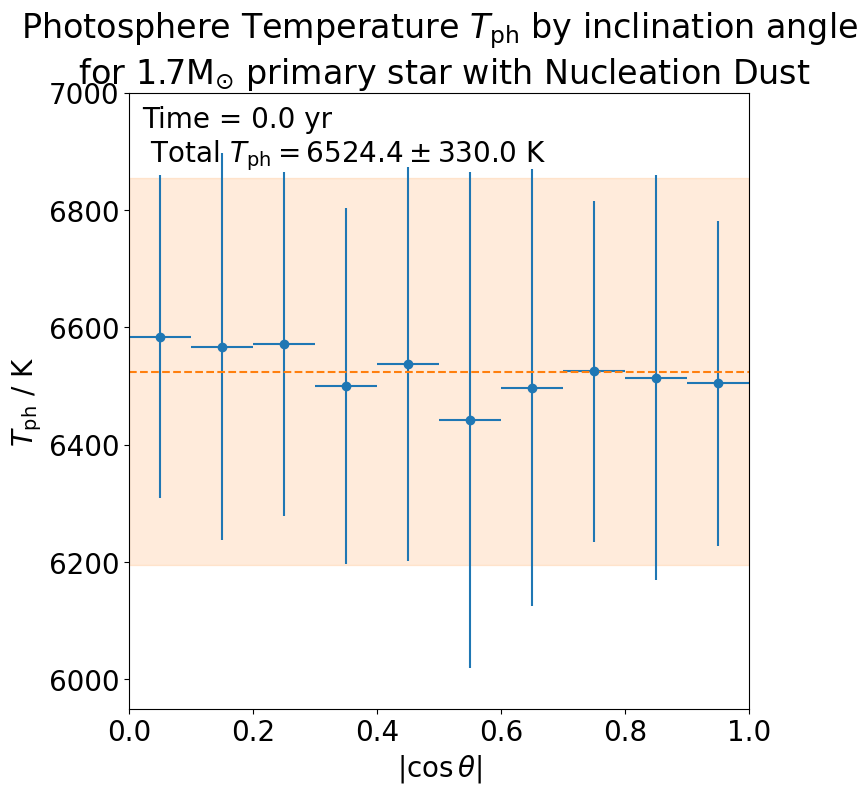

In [21]:
# plotting T vs inclination angle (combining negative and positive side of cos_theta)

if __name__ == '__main__':
    fig, ax = plt.subplots(figsize=(8, 8))
    x = cos_thetas
    halflen = int(len(x)/2)
    x = x[halflen:]
    xerr = cos_theta_delta

    y_data_full = [ vals_dict['T'] for vals_dict in vals_by_cos_thetas ]

    y_data = y_data_full[halflen:]
    y_data = [np.concatenate((y_data_full[i], y_data_full[-i-1])) for i in range(halflen-1, -1, -1)]
    
    y = np.average(y_data, axis = 1)
    yerr =  np.std(y_data, axis = 1)

    y_total = np.average(y_data_full, axis=None)
    y_total_err = np.std(y_data_full, axis=None)
    #ax.plot(x, y, 'o-')
    #ax.fill_between(x, y-yerr, y+yerr, alpha=0.15)
    ax.errorbar(x, y, yerr, xerr, 'o')

    ax.set_xlim((0., 1.))
    ax.set_ylim((5950, 7000))
    ax.set_xlabel("$ | \\cos{\\theta} | $")
    ax.set_ylabel(f"$T_\\mathrm{{ph}}$ / {mpdf.units['temp']}")

    ax.axhline(y_total, color='C1', linestyle='dashed')
    ax.fill_between((0., 1.), y_total-y_total_err, y_total+y_total_err, color='C1', alpha=0.15)
    
    ax.text(
        0.02, 0.98,
        f"Time = {mpdf.get_time():.1f}"
        f"\n Total $T_\\mathrm{{ph}} = {y_total:.1f}"
        f"\pm {y_total_err:.1f} $ {mpdf.units['temp']}",
        color = "black", ha = 'left', va = 'top',
        transform=ax.transAxes,
    )
    ax.set_title(
        "Photosphere Temperature $T_\\mathrm{{ph}}$ by inclination angle\n"
        #f"resolution = {mpdf.params['nparttot']:.2e}"
        f"{job_profile['plot_title_suffix']}"
    )

    outfilename_noext = f"{mpdf.get_filename()}__photosphere-vals_Tph-vs-incl"
    plt.savefig(f"{outfilename_noext}.png")
    print(f"Figure saved to {outfilename_noext}.png")

    plt.show()

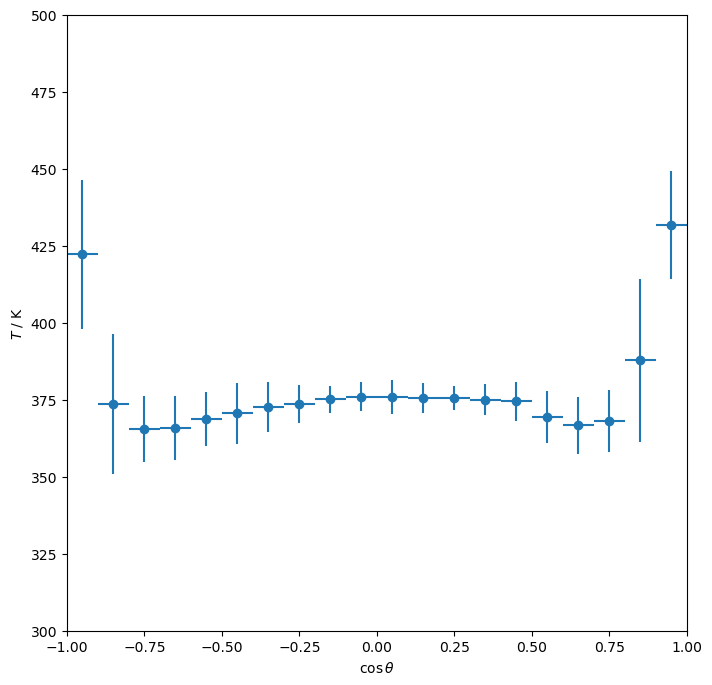

In [99]:
# plotting T vs inclination angle

if __name__ == '__main__':
    fig, ax = plt.subplots(figsize=(8, 8))
    x = cos_thetas
    xerr = cos_theta_delta
    y_data = [ vals_dict['T'] for vals_dict in vals_by_cos_thetas ]
    y = np.average(y_data, axis = 1)
    yerr =  np.std(y_data, axis = 1)
    #ax.plot(x, y, 'o-')
    #ax.fill_between(x, y-yerr, y+yerr, alpha=0.15)
    ax.errorbar(x, y, yerr, xerr, 'o')

    ax.set_xlim((-1., 1.))
    ax.set_ylim((300, 500))
    ax.set_xlabel("$\\cos{\\theta}$")
    ax.set_ylabel(f"$T$ / {mpdf.units['temp']}")

    plt.show()

In [58]:
np.average(vals_dict['T'])
np.std(vals_dict['T'])

18.224786722220546

In [52]:
vals_dict = get_ph_vals(['R1', 'T'], mpdf, eos, ray_no=100, verbose=verbose)
vals_dict

{'T': array([355.74374572, 368.17332467, 365.14967744, 373.98101733,
        438.54525006, 365.98326459, 377.04314074, 373.27595326,
        369.48725017, 379.32411659, 383.56885967, 358.77291298,
        373.32468029, 381.74321132, 380.303325  , 363.00333326,
        434.78446425, 373.83957929, 344.752934  , 374.12327245,
        359.03822908, 372.20305686, 376.01056258, 398.45460217,
        353.97105602, 373.96684207, 365.29444185, 357.39683087,
        376.06506408, 351.83885767, 368.76751152, 359.01501948,
        426.20103777, 358.22302126, 369.02877044, 382.80501438,
        361.03646806, 357.61362524, 366.63145742, 375.09094947,
        372.20968553, 361.45780142, 372.46916018, 378.80879105,
        371.10708192, 379.02295775, 378.59483731, 438.72503392,
        378.30258281, 366.42733174, 364.04296729, 369.86659513,
        357.02001996, 369.46056653, 372.74091773, 434.43832716,
        366.68213439, 378.67225914, 365.66959461, 362.90839602,
        458.93974452, 383.88087293,

In [47]:
photosphere['T']

363.474791873965

In [21]:
help(get_photosphere_on_ray)

Help on function get_photosphere_on_ray in module main.clmuphantomlib.light:

get_photosphere_on_ray(pts_on_ray, dtaus, pts_order, sdf, ray, calc_params: list = ['loc', 'R1'], hfact: float = None, mpart: float = None, eos: main.clmuphantomlib.eos_base.EoS_Base = None, sdf_units: dict = None, ray_unit_vec: numpy.ndarray = None, kernel: <module 'sarracen.kernels.base_kernel' from '/home/clmu/anaconda3/envs/clmu_1/lib/python3.11/site-packages/sarracen/kernels/base_kernel.py'> = None, do_skip_zero_dtau_pts: bool = True, photosphere_tau: float = 1.0, verbose: int = 0) -> (<class 'dict'>, (<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>))
    Calc the location where the photosphere intersect with the ray.
    
    Assuming 3D.
    
    
    Parameters
    ----------
    pts_on_ray, dtaus, pts_order
        output from get_optical_depth_by_ray_tracing_3D().
    
        pts_on_ray: np.ndarray
            Orthogonal projections of the particles' locations onto the ray

In [8]:
# functions

# plot_kappaProfile(job_name, file_index, eos_opacity, xlims, ylim, verbose)
def plot_kappaProfile(
    job_name: str, file_index: int, eos_opacity: EoS_MESA_opacity,
    xlims: dict,
    ylim: tuple,
    verbose: int,
) -> str:
    """Plot kappa Profile of a dump.

    Warning: assume a hard-coded constant kappa_gas as 2e-4 cm2/g

    Returns outfilename
    """
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)
    fig.subplots_adjust(wspace=0.0)
    mpdf = mupl.MyPhantomDataFrames().read(job_name, file_index, verbose=verbose) # reset_xyz_by_CoM=True, 
    #jobfilename = mupl.get_filename_phantom_dumps(job_name, file_index)
    jobfilename = mpdf.get_filename()
    # get temperature column label (one of the elem in the set below)
    temp_key = {'T', 'temperature', 'Tdust'}.intersection(mpdf.data['gas'].keys()).pop()
    mpdf.data['gas']['T'    ] = mpdf.data['gas'][temp_key]
    mpdf.data['gas']['kappa'] = get_val_in_unit(mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])

    y_orig = mpdf.get_val('kappa').to(unitsOut['opacity'])
    y_mesa = eos_opacity.get_kappa(mpdf.get_val('rho'), mpdf.get_val('T'), do_extrap=False).to(unitsOut['opacity'])
    y_extrap_indexes = np.where(~np.isfinite(y_mesa))[0]
    y_mesa_extrap = eos_opacity.get_kappa(
        mpdf.get_val('rho')[y_extrap_indexes], mpdf.get_val('T')[y_extrap_indexes], do_extrap=True).cgs

    # setting the switch between mesa opacity from phantom and nucleation opacity from luis
    # mesa opacity table from phantom uses Ferguson-2005-1 for opacity calc at low T (T < 1e4 K),
    #    which includes opacity from grains forming.
    #    We don't want that becaues we have our own carbon dust nucleation opacity.
    #    according to Ferguson-2005-1 fig9, grains dominates at T < 1450K (for logR=-3, X=0.7, Z=0.02)
    T_0, T_delta = 1450 * units.K, 50 * units.K
    x = mpdf.get_val('T').to(unitsOut['temp'], equivalencies=units.equivalencies.temperature())
    kappa_gas = (2e-4*(units.cm**2/units.g)).to(unitsOut['opacity'])
    y_comb = np.where(x < T_0, y_orig, y_orig - kappa_gas + y_mesa)

    
    # kappa vs temp
    ax = axes[0]
    x = mpdf.get_val('T').to(unitsOut['temp'], equivalencies=units.equivalencies.temperature())
    x_extrap = x[y_extrap_indexes]
    ax.loglog(x, y_orig, '.')
    ax.loglog(x, y_mesa, '.')
    ax.loglog(x_extrap, y_mesa_extrap, '.')
    ax.loglog(x, y_comb, '.', label='Blended')
    ax.set_xlim(xlims['T'])
    ax.set_ylim(ylim)
    ax.set_xlabel(f"$T$ / {x.unit.to_string('latex_inline')}")
    ax.set_ylabel(f"$\\kappa$ / {y_orig.unit.to_string('latex_inline')}")
    ax.text(
        0.02, 0.98,
        f"Time = {mpdf.get_time(unitsOut['time']):.1f}",
        color = "black", ha = 'left', va = 'top',
        transform=ax.transAxes,
    )

    # kappa vs rho
    ax = axes[1]
    x = mpdf.get_val('rho').to(unitsOut['density'])
    x_extrap = x[y_extrap_indexes]
    ax.loglog(x, y_orig, '.', label='Nucleation')
    ax.loglog(x, y_mesa, '.', label='MESA')
    ax.loglog(x_extrap, y_mesa_extrap, '.', label='MESA extrap')
    ax.loglog(x, y_comb, '.', label='Blended')
    ax.set_xlim(xlims['rho'])
    ax.set_ylim(ylim)
    ax.set_xlabel(f"$\\rho$ / {x.unit.to_string('latex_inline')}")
    ax.legend(loc='lower right')


    fig.suptitle(
        f"Opacity of all particles in the dump (different calculation method)\n"
        #f"resolution = {mpdf.params['nparttot']:.2e}\n"
        f"{job_profile['plot_title_suffix']}"
    )

    outfilename = f"{jobfilename}__kappaProfile.png"
    fig.savefig(outfilename)
    plt.close(fig)
    del mpdf

    return outfilename

In [27]:
key = '2md'
file_index  = 17600
job_profile = JOB_PROFILES_DICT[key]
job_name    = job_profile['job_name']
params      = job_profile['params']
mpdf = mupl.MyPhantomDataFrames().read(job_name, file_index, verbose=verbose)
temp_key = {'T', 'temperature', 'Tdust'}.intersection(mpdf.data['gas'].keys()).pop()
mpdf.data['gas']['T'    ] = mpdf.data['gas'][temp_key]
mpdf.get_val('T').min()

*   Note   :    MyPhantomDataFrames.read():
	
	Reading filename='../photosphere/luis_2md/light_17600'

**  Warning:    MyPhantomDataFrames.read():
	*    Warning: CoM significantly deviates from the origin,with distance of 15.877373716421248Consider use reset_xyz_by_CoM=True option when read.
**  Warning:    MyPhantomDataFrames.read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass")
	However in phantom kappa is often (?) assumed to be in cgs unit.
	
    If so, please CONVERT KAPPA MANNUALLY into PHANTOM UNITS, such as:
	
        mpdf.data['gas']['kappa'] = 
	mupl.get_val_in_unit(mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])


<Quantity 9.73556261 K>

In [9]:
do_debug = True

In [10]:
if __name__ == '__main__' and do_debug:
    ylim = (1e-6, 1e4)
    xlims= {
        'T'  : (  5.,  2e6),
        'rho': (2e-20, 1e-3),
    }
    
    key = '2md'
    file_index  = 17600
    job_profile = JOB_PROFILES_DICT[key]
    job_name    = job_profile['job_name']
    params      = job_profile['params']
    eos_opacity = EoS_MESA_opacity(params, settings)
    
    outfilename = plot_kappaProfile(job_name, file_index, eos_opacity, xlims, ylim, verbose)
    print(outfilename)

*   Note   :    MyPhantomDataFrames.read():
	
	Reading filename='../photosphere/luis_2md/light_17600'

**  Warning:    MyPhantomDataFrames.read():
	*    Warning: CoM significantly deviates from the origin,with distance of 15.877373716421248Consider use reset_xyz_by_CoM=True option when read.
**  Warning:    MyPhantomDataFrames.read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass")
	However in phantom kappa is often (?) assumed to be in cgs unit.
	
    If so, please CONVERT KAPPA MANNUALLY into PHANTOM UNITS, such as:
	
        mpdf.data['gas']['kappa'] = 
	mupl.get_val_in_unit(mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])
../photosphere/luis_2md/light_17600__kappaProfile.png


In [11]:
eos_opacity._log10_T_arr

array([2.8  , 2.825, 2.85 , 2.875, 2.9  , 2.925, 2.95 , 2.975, 3.   ,
       3.025, 3.05 , 3.075, 3.1  , 3.125, 3.15 , 3.175, 3.2  , 3.225,
       3.25 , 3.275, 3.3  , 3.325, 3.35 , 3.375, 3.4  , 3.425, 3.45 ,
       3.475, 3.5  , 3.525, 3.55 , 3.575, 3.6  , 3.625, 3.65 , 3.675,
       3.7  , 3.725, 3.75 , 3.775, 3.8  , 3.825, 3.85 , 3.875, 3.9  ,
       3.925, 3.95 , 3.975, 4.   , 4.025, 4.05 , 4.075, 4.1  , 4.125,
       4.15 , 4.175, 4.2  , 4.225, 4.25 , 4.275, 4.3  , 4.325, 4.35 ,
       4.375, 4.4  , 4.425, 4.45 , 4.475, 4.5  , 4.525, 4.55 , 4.575,
       4.6  , 4.625, 4.65 , 4.675, 4.7  , 4.725, 4.75 , 4.775, 4.8  ,
       4.825, 4.85 , 4.875, 4.9  , 4.925, 4.95 , 4.975, 5.   , 5.025,
       5.05 , 5.075, 5.1  , 5.125, 5.15 , 5.175, 5.2  , 5.225, 5.25 ,
       5.275, 5.3  , 5.325, 5.35 , 5.375, 5.4  , 5.425, 5.45 , 5.475,
       5.5  , 5.525, 5.55 , 5.575, 5.6  , 5.625, 5.65 , 5.675, 5.7  ,
       5.725, 5.75 , 5.775, 5.8  , 5.825, 5.85 , 5.875, 5.9  , 5.925,
       5.95 , 5.975,

In [15]:
10**9

1000000000

{'X': 0.691, 'Z': 0.021, 'mu': 2.381}


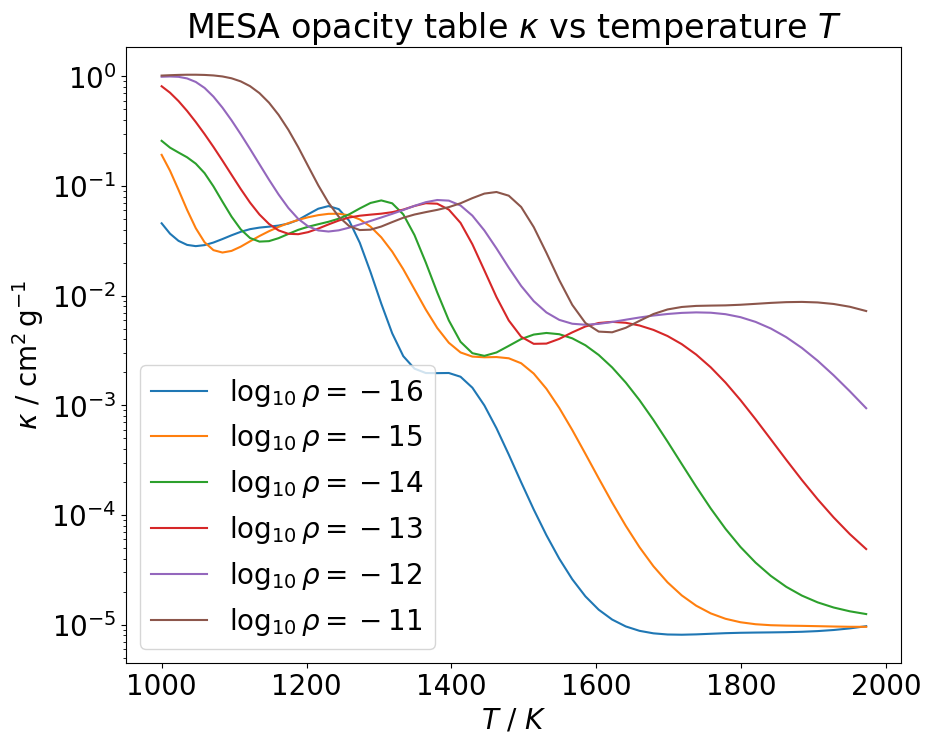

In [28]:
if __name__ == '__main__' and do_debug:
    params = JOB_PROFILES_DICT['2md']['params']
    #params = {'X': 0.7, 'Z': 0.02}  # the ones used in Ferguson-2005-1 fig9
    print(f"{params}")
    eos_opacity = EoS_MESA_opacity(params, settings)
    Ts = (10**np.arange(3., 3.3, 0.005))*units.K
    fig, ax = plt.subplots(figsize=(10, 8))
    for log10_rho in range(-16, -10, 1): #[-11.52]:
        # side note: log10_rho=-11.52 (i.e. log10_R=-3 when logT=3.16) is the one used in Ferguson-2005-1 fig9
        rho = (10**log10_rho)*(units.g/units.cm**3)
        kappas = eos_opacity.get_kappa(rho=rho, T=Ts, method='cubic') #, method='cubic'
        ax.semilogy(Ts.cgs, kappas.cgs, '-', label=f"$\\log_{{10}} \\rho = {log10_rho}$")

    ax.legend()
    ax.set_title("MESA opacity table $\\kappa$ vs temperature $T$")
    ax.set_ylabel(f"$\\kappa$ / {kappas.cgs.unit.to_string('latex_inline')}")
    ax.set_xlabel(f"$T$ / $K$")
    fig.savefig(f"main/test_mesa-opacity_kappa-T-rho.png")

In [ ]:
# plotting kappa vs Temp and kappa vs rho
if __name__ == '__main__':

    ylim = (1e-6, 1e4)
    xlims= {
        'T'  : (  5.,  2e6),
        'rho': (2e-20, 1e-3),
    }
    
    #mpdf = mupl.MyPhantomDataFrames()
    for key in ['2md', '4md']:
        job_profile = JOB_PROFILES_DICT[key]
        job_name    = job_profile['job_name']
        params      = job_profile['params']
        eos_opacity = EoS_MESA_opacity(params, settings)

        
        if NPROCESSES <= 1:

            # single process
            if __name__ == '__main__' and is_verbose(verbose, 'note'):
                say('note', "script_kappaProfile", verbose, f"Using single process.")
            
            outfilenames = []
            for file_index in job_profile['file_indexes']:
                outfilename = plot_kappaProfile(job_name, file_index, eos_opacity, xlims, ylim, verbose)
                outfilenames.append(outfilename)
        else:

            # multi-process
            if __name__ == '__main__' and is_verbose(verbose, 'note'):
                say('note', "script_kappaProfile", verbose, f"Using {NPROCESSES} processes.")
                
            args = [(job_name, file_index, eos_opacity, xlims, ylim, 0) for file_index in job_profile['file_indexes']]
            with Pool(processes=NPROCESSES) as pool:
                outfilenames = pool.starmap(plot_kappaProfile, args)


        # define job_folder_prefix
        for i in range(len(job_name)-1, -1, -1):
            if job_name[i] == path.sep:
                job_folder_prefix = job_name[:i]
                break
            else:
                job_folder_prefix = job_name
        with ImageSequenceClip(outfilenames, fps=fps) as vid:
            moviefilename = f"{job_folder_prefix}__kappaProfile__movie.mp4"
            vid.write_videofile(moviefilename)

    print("\n\n\n*** All Done. ***\n\n\n")

*   Note   :    MyPhantomDataFrames.read():
	Reading filename='../photosphere/luis_2md/light_00000'
*   Note: Reseting Origin to CoM...
    Note: CoM location is now: self.loc_CoM = array([ 0.00000000e+00,  3.59257537e-16, -1.80945419e-16])
**  Warning:    MyPhantomDataFrames.read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass")
	However in phantom kappa is often (?) assumed to be in cgs unit.
	
    If so, please COVERT KAPPA MANNUALLY into PHANTOM UNITS by using code, such as:
	
        mpdf.data['gas']['kappa'] = 
	mupl.set_as_quantity(mpdf.data['gas']['kappa'], units.cm**2/units.g).to_value(mpdf.units['opacity'])
*   Note   :    MyPhantomDataFrames.read():
	Reading filename='../photosphere/luis_2md/light_00100'
*   Note: Reseting Origin to CoM...
    Note: CoM location is now: self.loc_CoM = array([ 0.00000000e+00, -6.16342983e-15, -8.78770269e-16])
**  Warning:    MyPhantomDataFrames.read():
	kappa column exists.
	We he

if __name__ == '__main__':
    
    plt.close(fig)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    x = mpdf.get_val('T').to(unitsOut['temp'], equivalencies=units.equivalencies.temperature())
    y = mpdf.get_val('rho').to(unitsOut['density'])
    ax.loglog(x, y, '.')
    ax.text(
        0.95, 0.5,
        f"Time = {mpdf.get_time(unitsOut['time']):.1f}",
        color = "black", ha = 'right', va = 'top',
        transform=ax.transAxes,
    )
    ax.set_xlim(xlims['T'])
    ax.set_ylim(xlims['rho'])



